In [2]:
#importing libraries
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import hvplot.pandas
import scipy.stats as stats
import random

In [3]:
#reading in the csv file
staten_island_df = pd.read_csv("Resources/NYCCrimeData_Parks_Staten_Island_TableToExcel.csv")
staten_island_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OBJECTID      390 non-null    int64  
 1   Complaint ID  366 non-null    object 
 2   Offense       366 non-null    object 
 3   Latitude      390 non-null    float64
 4   Longitude     390 non-null    float64
 5   Borough       24 non-null     object 
 6   Public Area   24 non-null     object 
dtypes: float64(2), int64(1), object(4)
memory usage: 21.5+ KB


**Cleaning Data**

- the data frame is stacked on top of each other by the longitude and latitude columns
- we are simply breaking up the data into crimes and public institutions

In [4]:
#dividing the df into crimes and public institutions
r_crimes = staten_island_df.iloc[0:365, :]
r_crimes = r_crimes.drop(columns= ["Borough", "Public Area"])

In [5]:
r_crimes.head()

,OBJECTID,Complaint ID,Offense,Latitude,Longitude
0,1,261214832,ROBBERY,40.643566,-74.074001
1,2,261233859,ROBBERY,40.635961,-74.161365
2,3,261233841,ROBBERY,40.643569,-74.098338
3,4,261261343,ROBBERY,40.630408,-74.142977
4,5,261347872,ROBBERY,40.630539,-74.076641


In [6]:
#same method for public institutions and reordering columns
r_public = staten_island_df.iloc[366:389, :]
r_public = r_public.drop(columns= ["Complaint ID", "Offense"])
r_public = r_public[["OBJECTID", "Public Area", "Latitude", "Longitude"]]

In [7]:
r_public = r_public.reset_index()
r_public.head()

,index,OBJECTID,Public Area,Latitude,Longitude
0,366,367,PARKS,40.614533,-74.074185
1,367,368,RECREATION AND WATERFRONT SITES,40.510392,-74.230405
2,368,369,PUBLIC LIBRARIES,40.595802,-74.063027
3,369,370,PUBLIC LIBRARIES,40.590395,-74.101138
4,370,371,PARKS,40.638748,-74.083899


**Finding the Crimes that Occured Near Public Institutions**

- using GeoPandasDataFrame, we are marking the coordinates of each public institution
- then, we are finding the number of crimes that occured within a 1 mile radius of that institution
- we are looking at the results by type of crime which we have narrowed down to robbery, murder/manslaughter, and rape

In [8]:
#each location a crime took place, converted into a geodataframe

r_crimes_gdf = gpd.GeoDataFrame(
    r_crimes,
    geometry=gpd.points_from_xy(
        r_crimes["Latitude"],
        r_crimes["Longitude"],
    ),
    crs="EPSG:4326",
)

# each public institution

r_public_gdf = gpd.GeoDataFrame(
    r_public, 
    geometry=gpd.points_from_xy(
        r_public["Latitude"],
        r_public["Longitude"],
    ),
    crs="EPSG:4326",
)

# EPSG:3857 converts geometry points to meters

r_crimes_gdf = r_crimes_gdf.to_crs(3857)
r_public_gdf = r_public_gdf.to_crs(3857)

In [9]:
#thos portion of code returns all crimes commited within 1609 meters of a public institution
    # 1 miles would be 1609 meters

x = r_public_gdf.buffer(1609).unary_union

crimes_per = r_crimes_gdf["geometry"].intersection(x)

# print all the nearby points
all_crimes_near_pi = (r_crimes_gdf[~crimes_per.is_empty])
all_crimes_near_pi

,OBJECTID,Complaint ID,Offense,Latitude,Longitude,geometry
1,2,261233859,ROBBERY,40.635961,-74.161365,POINT (4523574.486 -12581036.663)
5,6,261434927,ROBBERY,40.637135,-74.123473,POINT (4523705.178 -12565599.692)
6,7,261431397,ROBBERY,40.643996,-74.076502,POINT (4524468.939 -12546513.640)
8,9,261493026,ROBBERY,40.634941,-74.086335,POINT (4523460.941 -12550504.598)
10,11,261586618,ROBBERY,40.636810,-74.118650,POINT (4523668.997 -12563637.356)
...,...,...,...,...,...,...
351,352,278833163,ROBBERY,40.643220,-74.075921,POINT (4524382.555 -12546277.902)
353,354,279006991,ROBBERY,40.643996,-74.076502,POINT (4524468.939 -12546513.640)
354,355,279031842,ROBBERY,40.645288,-74.085547,POINT (4524612.763 -12550184.681)
359,360,279208483,ROBBERY,40.644719,-74.081327,POINT (4524549.423 -12548471.682)


In [10]:
#this for loop returns a dataframe of the sum of each offense committed by each public institution

#create empty list to hold the number of crimes commited within a 1 mile radius of each public institution
crimes_per_location = []

# Define the radius in meters
radius = 1609 # about 1 mile

for offense in r_crimes_gdf["Offense"]:
    crimes_per_location = []
    r_crimes_gdf_each = r_crimes_gdf[r_crimes_gdf["Offense"] == offense]

    for i in range(len(r_public_gdf)):

        # Calculate the distances between all pairs of points
        distances = gpd.GeoSeries(r_crimes_gdf_each.geometry).distance(r_public_gdf.geometry.iloc[i])

        # Filter the pairs where the distance is within the radius
        within_radius = distances <= radius

        # Count the number of points within the radius for each point in gdf2
        count_within_radius = within_radius.sum()

        crimes_per_location.append(count_within_radius)
    r_public_gdf[offense] = crimes_per_location

In [11]:
#creating a column for the sum amount of offenses
r_public_gdf["Total Crimes"] = r_public_gdf[['ROBBERY', 'MURDER & NON-NEGL. MANSLAUGHTER', 'RAPE']].sum(axis=1)
r_public_gdf

,index,OBJECTID,Public Area,Latitude,Longitude,geometry,ROBBERY,MURDER & NON-NEGL. MANSLAUGHTER,RAPE,Total Crimes
0,366,367,PARKS,40.614533,-74.074185,POINT (4521189.101 -12545573.503),10,1,0,11
1,367,368,RECREATION AND WATERFRONT SITES,40.510392,-74.230405,POINT (4509596.170 -12609255.973),0,0,0,0
2,368,369,PUBLIC LIBRARIES,40.595802,-74.063027,POINT (4519103.997 -12541048.240),5,0,0,5
3,369,370,PUBLIC LIBRARIES,40.590395,-74.101138,POINT (4518502.095 -12556517.429),2,0,0,2
4,370,371,PARKS,40.638748,-74.083899,POINT (4523884.728 -12549515.585),24,0,0,24
5,371,372,PARKS,40.636564,-74.160471,POINT (4523641.579 -12580672.111),4,1,0,5
6,372,373,PRESERVES AND CONSERVATION AREAS,40.576267,-74.203381,POINT (4516929.352 -12598196.087),0,0,0,0
7,373,374,PARKS,40.608690,-74.119578,POINT (4520538.708 -12564014.907),10,0,0,10
8,374,375,CEMETERIES,40.639297,-74.120934,POINT (4523945.891 -12564566.701),6,1,0,7
9,375,376,GARDENS,40.526901,-74.163615,POINT (4511433.992 -12581954.507),0,0,0,0


In [12]:
#there are 7 types of public areas
#should I group gardens, parks, conservation, and waterfront sites under one heading for simplicity?
#public libraries and malls are two distinct areas from the other 5

reduced_r_public_gdf = r_public_gdf
reduced_r_public_gdf["Public Area"] = reduced_r_public_gdf["Public Area"].replace(
       ['PARKS', 'RECREATION AND WATERFRONT SITES',
        'PRESERVES AND CONSERVATION AREAS', 'CEMETERIES', 'GARDENS'],
        "Parks and Other Outdoor Areas"
)

reduced_r_public_gdf

,index,OBJECTID,Public Area,Latitude,Longitude,geometry,ROBBERY,MURDER & NON-NEGL. MANSLAUGHTER,RAPE,Total Crimes
0,366,367,Parks and Other Outdoor Areas,40.614533,-74.074185,POINT (4521189.101 -12545573.503),10,1,0,11
1,367,368,Parks and Other Outdoor Areas,40.510392,-74.230405,POINT (4509596.170 -12609255.973),0,0,0,0
2,368,369,PUBLIC LIBRARIES,40.595802,-74.063027,POINT (4519103.997 -12541048.240),5,0,0,5
3,369,370,PUBLIC LIBRARIES,40.590395,-74.101138,POINT (4518502.095 -12556517.429),2,0,0,2
4,370,371,Parks and Other Outdoor Areas,40.638748,-74.083899,POINT (4523884.728 -12549515.585),24,0,0,24
5,371,372,Parks and Other Outdoor Areas,40.636564,-74.160471,POINT (4523641.579 -12580672.111),4,1,0,5
6,372,373,Parks and Other Outdoor Areas,40.576267,-74.203381,POINT (4516929.352 -12598196.087),0,0,0,0
7,373,374,Parks and Other Outdoor Areas,40.608690,-74.119578,POINT (4520538.708 -12564014.907),10,0,0,10
8,374,375,Parks and Other Outdoor Areas,40.639297,-74.120934,POINT (4523945.891 -12564566.701),6,1,0,7
9,375,376,Parks and Other Outdoor Areas,40.526901,-74.163615,POINT (4511433.992 -12581954.507),0,0,0,0


In [13]:
r_summary_stats = reduced_r_public_gdf.groupby("Public Area")[['ROBBERY', 'MURDER & NON-NEGL. MANSLAUGHTER', 'RAPE', 'Total Crimes']].describe()
r_summary_stats["ROBBERY"]

,count,mean,std,min,25%,50%,75%,max
Public Area,,,,,,,,
PUBLIC LIBRARIES,4.0,2.500000,1.732051,1.0,1.75,2.0,2.75,5.0
Parks and Other Outdoor Areas,18.0,8.111111,11.034112,0.0,0.25,4.5,9.75,41.0
"STREETSCAPES, PLAZAS, AND MALLS",1.0,5.000000,NaN,5.0,5.00,5.0,5.00,5.0


**Finding the Control Data**

- what i want to do is grab a random series of coordinates within staten island and see the number of crimes occured in the same radius
- then compare them to library/park data to see if there is a significant difference

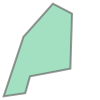

In [14]:
# Coordinates for the polygon of staten island
# Coordinates determined by HeadWall photonics (http://apps.headwallphotonics.com)

staten_island_poly = Polygon([
    (40.5004753162685, -74.24873416273303),
    (40.54484131402899, -74.24221103040881),
    (40.554754403637595, -74.20753543226428),
    (40.6379143073708, -74.19174258558459),
    (40.64130107521177, -74.07844607679553),
    (40.60195187161857, -74.05784671156115),
    (40.5411887532192, -74.1261679395885)
])
staten_island_poly

In [15]:
# Defining the randomization generator
#code adjusted from online source published by Ayush Sethi

def polygon_random_points (poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
            random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
            if (random_point.within(poly)):
                points.append(random_point)
    return points

In [16]:
# Choose the number of points desired. This method uses 100 points. 
points = polygon_random_points(staten_island_poly, 100)
# Printing the results.
for p in points:
    print(p.x,",",p.y)

40.62254676702444 , -74.07886464442501
40.61078147487423 , -74.14281374160949
40.627872519151744 , -74.08360321685869
40.62907567413285 , -74.18303129946509
40.561585365239196 , -74.15853264499945
40.60534273843619 , -74.15314046254117
40.59951003761904 , -74.10206141244188
40.566348684534276 , -74.13299203940879
40.57484754564281 , -74.12338744575636
40.64019692708953 , -74.08007936973416
40.61287632856035 , -74.06382720045568
40.59850415535834 , -74.06460225991991
40.60059512192566 , -74.12847139247967
40.539231638983864 , -74.15973970457195
40.58255271913774 , -74.15885816615345
40.58870563027242 , -74.15187473659078
40.621696142493676 , -74.08769901147616
40.60825651262192 , -74.11474875598813
40.580759035844366 , -74.0890103445106
40.58258199346813 , -74.14377477490548
40.58670563006216 , -74.18132196087139
40.5942348613698 , -74.18642613492672
40.53359964295303 , -74.1643234284497
40.54081988243356 , -74.21889346687857
40.63911824694821 , -74.11169521796012
40.54119332110299 , -7

In [17]:
#creating a gdf out of the random points
r_random_gdf = gpd.GeoDataFrame(points,
                                geometry= points,
                                crs= "EPSG:4326")
#this step is for mapping later
r_random_gdf['Latitude'] = r_random_gdf['geometry'].x
r_random_gdf['Longitude'] = r_random_gdf['geometry'].y

#converting to meters
r_random_gdf = r_random_gdf.to_crs(3857)
r_random_gdf.head()

,0,geometry,Latitude,Longitude
0,POINT (40.62254676702444 -74.07886464442501),POINT (4522081.221 -12547472.357),40.622547,-74.078865
1,POINT (40.61078147487423 -74.14281374160949),POINT (4520771.514 -12573474.480),40.610781,-74.142814
2,POINT (40.62787251915174 -74.08360321685869),POINT (4522674.081 -12549395.598),40.627873,-74.083603
3,POINT (40.62907567413285 -74.18303129946509),POINT (4522808.015 -12589879.586),40.629076,-74.183031
4,POINT (40.5615853652392 -74.15853264499945),POINT (4515295.029 -12579881.532),40.561585,-74.158533


In [18]:
#repeating method to get number of crimes within a mile radius of each random point
#create empty list to hold the number of crimes commited within a 1 mile radius of each location
crimes_per_location = []

# Define the radius in meters
radius = 1609 # about 1 mile

for offense in r_crimes_gdf["Offense"]:
    crimes_per_location = []
    r_crimes_gdf_each = r_crimes_gdf[r_crimes_gdf["Offense"] == offense]

    for i in range(len(r_random_gdf)):

        # Calculate the distances between all pairs of points
        distances = gpd.GeoSeries(r_crimes_gdf_each.geometry).distance(r_random_gdf.geometry.iloc[i])

        # Filter the pairs where the distance is within the radius
        within_radius = distances <= radius

        # Count the number of points within the radius for each point in gdf2
        count_within_radius = within_radius.sum()

        crimes_per_location.append(count_within_radius)
    r_random_gdf[offense] = crimes_per_location

In [19]:
#creating sum column and seeing descriptive stats
r_random_gdf["Total Crimes"] = r_random_gdf[['ROBBERY', 'MURDER & NON-NEGL. MANSLAUGHTER', 'RAPE']].sum(axis=1)
r_random_gdf[["ROBBERY", "MURDER & NON-NEGL. MANSLAUGHTER", "RAPE", "Total Crimes"]].describe()

,ROBBERY,MURDER & NON-NEGL. MANSLAUGHTER,RAPE,Total Crimes
count,100.00000,100.000000,100.000000,100.000000
mean,3.87000,0.240000,0.460000,4.570000
std,7.31907,0.653197,2.133996,8.829765
min,0.00000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000
50%,1.00000,0.000000,0.000000,1.000000
75%,3.00000,0.000000,0.000000,4.000000
max,38.00000,4.000000,15.000000,54.000000


In [20]:
r_random_gdf

,0,geometry,Latitude,Longitude,ROBBERY,MURDER & NON-NEGL. MANSLAUGHTER,RAPE,Total Crimes
0,POINT (40.62254676702444 -74.07886464442501),POINT (4522081.221 -12547472.357),40.622547,-74.078865,25,4,0,29
1,POINT (40.61078147487423 -74.14281374160949),POINT (4520771.514 -12573474.480),40.610781,-74.142814,1,0,0,1
2,POINT (40.62787251915174 -74.08360321685869),POINT (4522674.081 -12549395.598),40.627873,-74.083603,33,3,0,36
3,POINT (40.62907567413285 -74.18303129946509),POINT (4522808.015 -12589879.586),40.629076,-74.183031,0,0,0,0
4,POINT (40.5615853652392 -74.15853264499945),POINT (4515295.029 -12579881.532),40.561585,-74.158533,2,0,0,2
...,...,...,...,...,...,...,...,...
95,POINT (40.50825136918083 -74.23169840279333),POINT (4509357.915 -12609785.781),40.508251,-74.231698,0,0,0,0
96,POINT (40.56183611822808 -74.10757595507395),POINT (4515322.942 -12559133.955),40.561836,-74.107576,3,0,7,10
97,POINT (40.57120543661656 -74.11039563346483),POINT (4516365.930 -12560280.323),40.571205,-74.110396,6,0,0,6
98,POINT (40.62410720652523 -74.10850564360064),POINT (4522254.928 -12559511.907),40.624107,-74.108506,1,0,0,1


**Is There A Signficant Difference in the Amount of Crime Commited by a Public Institution vs Not?**
- Null Hypothesis: there is no difference between the rate of crime by a public institution vs not near a public institution
- Alternate Hypothesis: if within a 1 mile radius of a public institution, then there is a lower rate of crime

- What am I comparing?
    - the true mean of crime committed within a mile of a public library and park respectively
    - the true mean of crime committed within a mile radius anywhere in Staten Island


In [21]:
#Significance Tests
    #this won't be the same in the other boroughs because their sample sizes will be above 30, but because the sample size in staten island is <30 we will be using a t-test
def ttests(df, df2):
    for crime in df.columns:
        try:
            print(f"{crime}: {stats.ttest_ind(df[crime], df2[crime], equal_var=False)}")
        except:
            print("NA")

#dividing public areas into libraries and other. not doing malls bc there is only one data point for that
libraries = reduced_r_public_gdf[reduced_r_public_gdf["Public Area"] == "PUBLIC LIBRARIES"]
parks = reduced_r_public_gdf[reduced_r_public_gdf["Public Area"] == "Parks and Other Outdoor Areas"]



In [22]:
# no significance found for any crime, unable to reject null hypo

ttests(reduced_r_public_gdf, r_random_gdf)

NA
NA
NA
Latitude: TtestResult(statistic=0.17481792971791063, pvalue=0.8624472695857137, df=28.767874811991312)
Longitude: TtestResult(statistic=0.9998756290963783, pvalue=0.3256084315977844, df=29.116227906945102)
NA
ROBBERY: TtestResult(statistic=1.4204039975929579, pvalue=0.1666491766694233, df=27.699495808527455)
MURDER & NON-NEGL. MANSLAUGHTER: TtestResult(statistic=0.18281993192777277, pvalue=0.8557392165554121, df=46.200676417422464)
RAPE: TtestResult(statistic=0.28005532007010725, pvalue=0.7815778726648963, df=26.89468549461168)
Total Crimes: TtestResult(statistic=1.218889104730429, pvalue=0.2333140213788295, df=27.300642080165275)


In [23]:
# p-value < .05 for murder & non negl homocide, able to reject null hypo
# no significance found for any other crime, unable to reject null hypo

print(ttests(libraries, r_random_gdf))

NA
NA
NA
Latitude: TtestResult(statistic=-1.3593234845226463, pvalue=0.2624356467813923, df=3.1792330820465025)
Longitude: TtestResult(statistic=-0.066979623567768, pvalue=0.9507295192375032, df=3.0643318774758743)
NA
ROBBERY: TtestResult(statistic=-1.2082388399564796, pvalue=0.25883522162335953, df=8.681751402517822)
MURDER & NON-NEGL. MANSLAUGHTER: TtestResult(statistic=-3.6742346141747664, pvalue=0.0003873122498296649, df=99.0)
RAPE: TtestResult(statistic=-2.1555803125601067, pvalue=0.03354013974715751, df=98.99999999999999)
Total Crimes: TtestResult(statistic=-1.6736886400385016, pvalue=0.11986039730549013, df=12.083363948449435)
None


In [24]:
# no significance found for any crime, unable to reject null hypo

print(ttests(parks, r_random_gdf))

NA
NA
NA
Latitude: TtestResult(statistic=0.5635256032973777, pvalue=0.578992404336746, df=21.189917340541346)
Longitude: TtestResult(statistic=1.0588056248679458, pvalue=0.3009448523173355, df=22.456712702206893)
NA
ROBBERY: TtestResult(statistic=1.5697413911366311, pvalue=0.13233626172081467, df=19.77802835033007)
MURDER & NON-NEGL. MANSLAUGHTER: TtestResult(statistic=0.708810655418796, pvalue=0.484030430779976, df=29.371401283012638)
RAPE: TtestResult(statistic=0.43399592390969693, pvalue=0.6691070391475966, df=19.288470636641204)
Total Crimes: TtestResult(statistic=1.395567533480014, pvalue=0.17847595289541085, df=19.574530324281817)
None


**Mapping the Locations**
- mapping the areas where crime took place
- mapping each public institution in Staten Island
- comparing to the random locations

In [31]:
#mapping areas where crime took place
    #note that a majority of crime takes place on the north side of Staten Island

r_crime_map = r_crimes_gdf.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    color = "Offense",
    alpha = 0.80
)

r_crime_map

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Offense)

In [32]:
r_public_map = r_public_gdf.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    color = "Public Area",
    alpha = 0.5,
    hover_cols = ['ROBBERY', 'MURDER & NON-NEGL. MANSLAUGHTER', 'RAPE', 'Total Crimes']
)
r_public_map

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Public Area,ROBBERY,MURDER & NON-NEGL. MANSLAUGHTER,RAPE,Total Crimes)

In [33]:
#map of random coordinates for comparision
r_random_map = r_random_gdf.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    alpha = 0.5
)
r_random_map

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]